In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import deepRD
import deepRD.tools.analysisTools as analysisTools

In [11]:
def read_numpy_arrays_from_file(file_path):
    arrays = []
    with open(file_path, 'r') as file:
        contents = file.read()

    # Split the file content based on square brackets [ ]
    array_strings = contents.split('[')[1:]

    # Convert each array string back to a numpy array and store it
    for array_string in array_strings:
        array = np.fromstring(array_string.replace(']', ''), sep=' ')
        arrays.append(array)

    return arrays

In [19]:
# Load parameters from parameters file
simID = '0001'
localDataDirectory = os.environ.get('DATA') + 'openSystems/classicSmoluchowski_' + simID
parameterDictionary = analysisTools.readParameters(localDataDirectory + "/parameters_" + simID)
# Parameters for loading continuous trajectories from files (from original simulation)
numSimulations = parameterDictionary['numSimulations']
D = parameterDictionary['D'] 
dt = parameterDictionary['dt']
stride = parameterDictionary['stride']
tfinal = parameterDictionary['tfinal']
kappa = parameterDictionary['kappa'] 
sigma = parameterDictionary['sigma']
R = parameterDictionary['R']
cR = parameterDictionary['cR']
equilibrationSteps = parameterDictionary['equilibrationSteps']

In [20]:
# Read files
file_path = localDataDirectory + '/classicSmol_nsims' + str(numSimulations) + '.xyz'
distancesArrays = read_numpy_arrays_from_file(file_path)

In [27]:
print(len(distancesArrays),cR)

1000 1.0


In [22]:
# Calculate average concentration with bootstrapping stdDevs
nbins = 30
#numSimulations = 1500
# Calculate values of middle points of histogram
hist, bins = np.histogram(distancesArrays[0], bins=nbins, range=(sigma,R))
rvals = np.zeros(len(bins)-1)
rvolumes = np.zeros(len(bins)-1)
binsize = bins[1]-bins[0]
for i in range(len(bins)-1):
    rvals[i] = (bins[i+1] + bins[i])/2.0
    rvolumes[i] = 4*np.pi*(bins[i+1]**3 - bins[i]**3)/3.0 # Approx alternative: 4*np.pi* rvals[i]**2*(bins[i+1]-bins[i])
# Calculate average concentration
concentrationHistogram = np.zeros(len(bins)-1)
stdDevs = np.zeros(len(bins)-1)
concHist = [None]*numSimulations
for i in range(numSimulations):
    hist, bins = np.histogram(distancesArrays[i], bins=nbins, range=(sigma,R))
    concHist[i] = hist/rvolumes
for j in range(len(concentrationHistogram)):
    concentrationHistogram[j] = np.mean(np.array(concHist)[:,j])
    stdDevs[j] = np.std(np.array(concHist)[:,j])

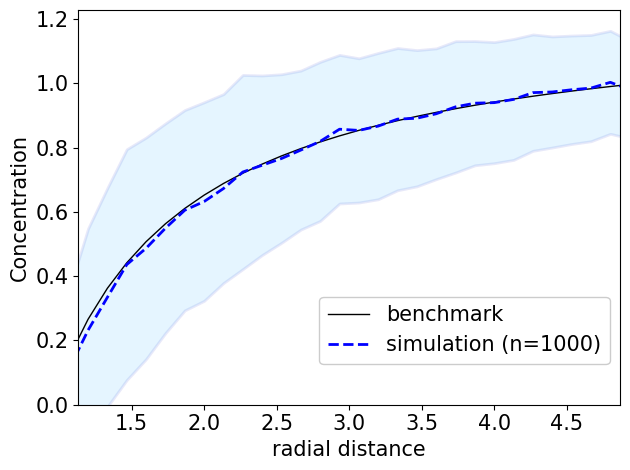

In [23]:
fig, ax = plt.subplots()
bw=0.1
fsize = 15
# Calculate analytical solution
#kappa = 10
#sigma = 1.0 
#R = 10.0
#cR = 1.0
#rvals = np.arange(sigma,R,0.1)
kS = 4*np.pi*sigma*D
analyticCKRinf = cR*(1 - kappa*sigma/(kS + kappa)*(1/rvals))
analyticCK = cR*(1 - kappa*sigma/(kS + kappa*(1-sigma/R))*(1.0/rvals - 1.0/R))


ax.plot(rvals, analyticCK,'-k', linewidth =1, label='benchmark')
ax.plot(rvals, concentrationHistogram,'--b', linewidth = 2, label='simulation (n='+ str(numSimulations)+')')
ax.fill_between(rvals, concentrationHistogram-stdDevs, concentrationHistogram+stdDevs, alpha=0.1, 
                edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=2, antialiased=True)
#ax.plot(rvals, analyticCKRinf,'-r', lw =3, label='benchmark Rinf')

ax.set_xlim((sigma+binsize, R-binsize))
ax.set_ylim((0, None))
ax.set_xlabel('radial distance',fontsize=fsize)
ax.set_ylabel('Concentration',fontsize=fsize)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)



ax.legend(bbox_to_anchor=(0.6, 0., 0.4, 0.3), framealpha=1.0,fontsize=fsize)

plt.tight_layout()

## Plots for paper

In [24]:
# Calculate average concentration
nSimsList = [100,500,1000]
concentrationHistograms=[None]*len(nSimsList)
stdDevs = [None]*len(nSimsList)
for k, nsims in enumerate(nSimsList):
    concentrationHistograms[k] = np.zeros(nbins)
    stdDevs[k] = np.zeros(nbins)
    concHist = [None]*nsims
    for i in range(nsims):
        hist, bins = np.histogram(distancesArrays[i], bins=nbins, range=(sigma,R))
        concHist[i] = hist/rvolumes
    for j in range(len(concentrationHistograms[k])):
        concentrationHistograms[k][j] = np.mean(np.array(concHist)[:,j])
        stdDevs[k][j] = np.std(np.array(concHist)[:,j])

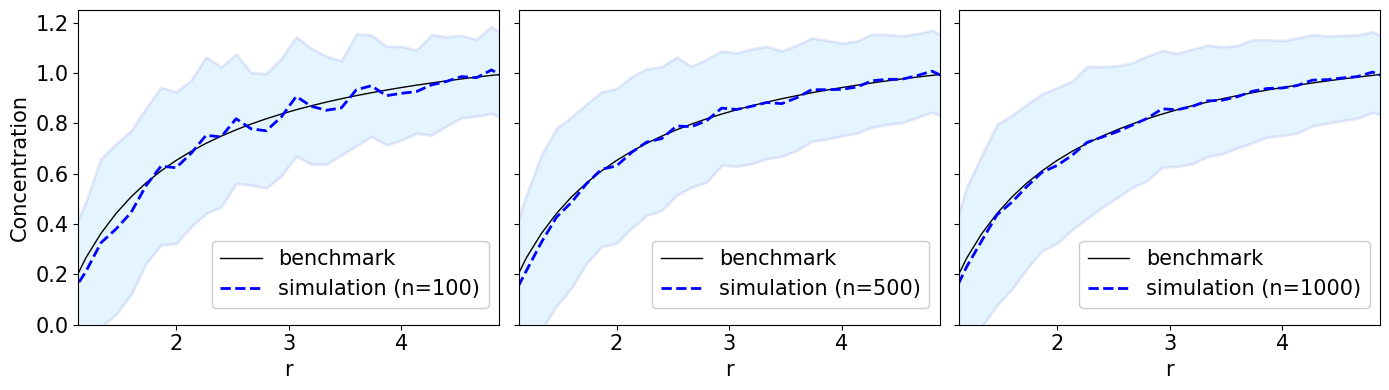

In [25]:
fig, ax = plt.subplots(1,3, figsize=(14,4), sharey=True, squeeze= True)
bw=0.1
fsize = 15

#Analytical solution
kS = 4*np.pi*sigma*D
analyticCKRinf = cR*(1 - kappa*sigma/(kS + kappa)*(1/rvals))
analyticCK = cR*(1 - kappa*sigma/(kS + kappa*(1-sigma/R))*(1.0/rvals - 1.0/R))

for k, nsims in enumerate(nSimsList):
    ax[k].plot(rvals, analyticCK,'-k', linewidth =1, label='benchmark')
    ax[k].plot(rvals, concentrationHistograms[k],'--b', linewidth = 2, label='simulation (n='+ str(nsims) + ')')
    ax[k].fill_between(rvals, concentrationHistograms[k]-stdDevs[k], concentrationHistograms[k]+stdDevs[k], alpha=0.1, 
                    edgecolor='#1B2ACC', facecolor='#089FFF', linewidth=2, antialiased=True)
    #ax.plot(rvals, analyticCKRinf,'-r', lw =3, label='benchmark Rinf')

    ax[k].set_xlim((sigma+binsize, R-binsize))
    ax[k].set_ylim((0, 1.25))
    #ax[k].set_ylim((0, 0.75))
    ax[k].set_xlabel('r',fontsize=fsize)
    ax[k].tick_params(axis='x', labelsize=fsize)
    ax[k].tick_params(axis='y', labelsize=fsize)
    ax[k].legend(bbox_to_anchor=(0.6, 0., 0.4, 0.3), framealpha=1.0,fontsize=fsize)


ax[0].set_ylabel('Concentration',fontsize=fsize)

plt.tight_layout()
plt.savefig('Smoluchowski_plots_cR=' + str(cR) + '.pdf')

### Error plots for partially absorbing boundary

In [261]:
# Load files
#numdts = 6
#simIDs = ['0012','0013','0014','0016','0017','0018','0022','0023','0024','0026','0027','0028'] 
numdts = 4
simIDs = ['0011','0012','0013','0014','0021','0022','0023','0024'] 
numSimulations = 1000
distancesArraysList = [None]*len(simIDs)
dtList = [None]*len(simIDs)
for i, ID in enumerate(simIDs):
    localDataDirectory = os.environ.get('DATA') + 'openSystems/classicSmoluchowski_' + ID
    parameterDictionary = analysisTools.readParameters(localDataDirectory + "/parameters_" + ID)
    file_path = localDataDirectory + '/classicSmol_nsims' + str(numSimulations) + '.xyz'
    distancesArraysList[i] = read_numpy_arrays_from_file(file_path)
    dtList[i] = parameterDictionary['dt']
    if i==0: # Assumes all other parameters are the same for all simIDs
        # Parameters for loading continuous trajectories from files (from original simulation)
        numSimulations = parameterDictionary['numSimulations']
        D = parameterDictionary['D'] 
        stride = parameterDictionary['stride']
        tfinal = parameterDictionary['tfinal']
        kappa = parameterDictionary['kappa'] 
        sigma = parameterDictionary['sigma']
        R = parameterDictionary['R']
        cR = parameterDictionary['cR']
        equilibrationSteps = parameterDictionary['equilibrationSteps']

In [270]:
numSimulations = 440

In [271]:
# Choose histogram Calculate values of middle points of histogram
nbins = 40
hist, bins = np.histogram(distancesArraysList[0][0], bins=nbins, range=(sigma,R))
rvals = np.zeros(len(bins)-1)
rvolumes = np.zeros(len(bins)-1)
binsize = bins[1]-bins[0]
for i in range(len(bins)-1):
    rvals[i] = (bins[i+1] + bins[i])/2.0
    rvolumes[i] = 4*np.pi*(bins[i+1]**3 - bins[i]**3)/3.0 # Approx alternative: 4*np.pi* rvals[i]**2*(bins[i+1]-bins[i])

In [272]:
# Calculate average concentration
concentrationHistograms=[None]*len(simIDs)
stdDevs = [None]*len(simIDs)
for k, ID in enumerate(simIDs):
    concentrationHistograms[k] = np.zeros(nbins)
    stdDevs[k] = np.zeros(nbins)
    concHist = [None]*numSimulations
    for i in range(numSimulations):
        hist, bins = np.histogram(distancesArraysList[k][i], bins=nbins, range=(sigma,R))
        concHist[i] = hist/rvolumes
    for j in range(len(concentrationHistograms[k])):
        concentrationHistograms[k][j] = np.mean(np.array(concHist)[:,j])
        stdDevs[k][j] = np.std(np.array(concHist)[:,j])

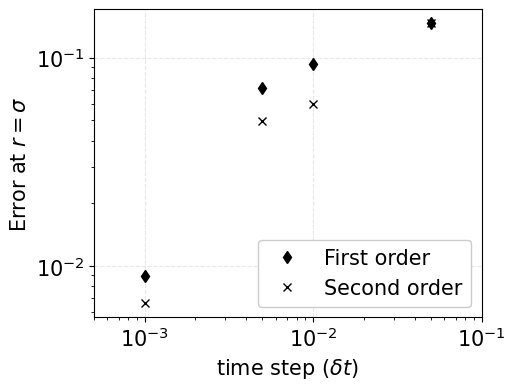

In [286]:
# Extract and plot last values at partially absorbing boundary
#analyticVal = analyticCK[0]
analyticVal = 0.5*(analyticCK[0]+analyticCK[1])
errorList = [None]*len(simIDs)
for k, ID in enumerate(simIDs):
    #numericalVal = concentrationHistograms[k][0]
    numericalVal = 0.5*(concentrationHistograms[k][0] + concentrationHistograms[k][1])
    errorList[k] = np.abs(numericalVal - analyticVal)

fig, ax = plt.subplots(1,1, figsize=(5,4))    
#ax.plot(dtList[0:numdts],dtList[0:numdts], 'k--')
ax.plot(dtList[0:numdts], errorList[0:numdts], 'kd',label="First order")
ax.plot(dtList[numdts:], errorList[numdts:], 'kx',label="Second order")
ax.set_xlabel(r'time step ($\delta t$)',fontsize=fsize)
ax.set_ylabel(r'Error at $r=\sigma$',fontsize=fsize)
ax.set_xscale('log')
ax.set_xlim([0.0005,0.1])
ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.legend(framealpha=1.0,fontsize=fsize)
ax.grid(linestyle = '--',alpha=0.3)

### Error plots for reservoir

In [355]:
# Load files
simIDs = ['0031','0032','0033','0034','0035','0036'] 
numSimulations = 1000
distancesArraysList = [None]*len(simIDs)
tauStepsList = [1,2,4,6,8,10]
for i, ID in enumerate(simIDs):
    localDataDirectory = os.environ.get('DATA') + 'openSystems/classicSmoluchowski_' + ID
    parameterDictionary = analysisTools.readParameters(localDataDirectory + "/parameters_" + ID)
    file_path = localDataDirectory + '/classicSmol_nsims' + str(numSimulations) + '.xyz'
    distancesArraysList[i] = read_numpy_arrays_from_file(file_path)
    dtList[i] = parameterDictionary['dt']
    if i==0: # Assumes all other parameters are the same for all simIDs
        # Parameters for loading continuous trajectories from files (from original simulation)
        numSimulations = parameterDictionary['numSimulations']
        D = parameterDictionary['D'] 
        dt = parameterDictionary['dt']
        stride = parameterDictionary['stride']
        tfinal = parameterDictionary['tfinal']
        kappa = parameterDictionary['kappa'] 
        sigma = parameterDictionary['sigma']
        R = parameterDictionary['R']
        cR = parameterDictionary['cR']
        equilibrationSteps = parameterDictionary['equilibrationSteps']

In [356]:
numSimulations = 1

In [357]:
# Choose histogram Calculate values of middle points of histogram
nbins = 40
hist, bins = np.histogram(distancesArraysList[0][0], bins=nbins, range=(sigma,R))
rvals = np.zeros(len(bins)-1)
rvolumes = np.zeros(len(bins)-1)
binsize = bins[1]-bins[0]
for i in range(len(bins)-1):
    rvals[i] = (bins[i+1] + bins[i])/2.0
    rvolumes[i] = 4*np.pi*(bins[i+1]**3 - bins[i]**3)/3.0 # Approx alternative: 4*np.pi* rvals[i]**2*(bins[i+1]-bins[i])

In [358]:
# Calculate average concentration
concentrationHistograms=[None]*len(simIDs)
stdDevs = [None]*len(simIDs)
for k, ID in enumerate(simIDs):
    concentrationHistograms[k] = np.zeros(nbins)
    stdDevs[k] = np.zeros(nbins)
    concHist = [None]*numSimulations
    for i in range(numSimulations):
        hist, bins = np.histogram(distancesArraysList[k][i], bins=nbins, range=(sigma,R))
        concHist[i] = hist/rvolumes
    for j in range(len(concentrationHistograms[k])):
        concentrationHistograms[k][j] = np.mean(np.array(concHist)[:,j])
        stdDevs[k][j] = np.std(np.array(concHist)[:,j])

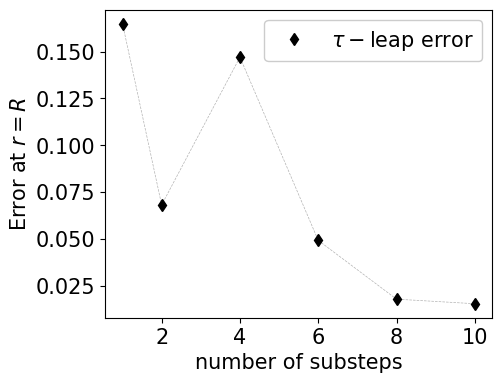

In [361]:
# Extract and plot last values at partially absorbing boundary
#analyticVal = analyticCK[-1]
analyticVal = 0.5*(analyticCK[-1] + analyticCK[-2])
errorListTau = [None]*len(simIDs)
for k, ID in enumerate(simIDs):
    #numericalVal = concentrationHistograms[k][-1]
    numericalVal = 0.5*(concentrationHistograms[k][-1] + concentrationHistograms[k][-2])
    errorListTau[k] = np.abs(numericalVal - analyticVal)

fig, ax = plt.subplots(1,1, figsize=(5,4))    
ax.plot(tauStepsList, errorListTau, 'k--', alpha = 0.3, lw=0.5)
ax.plot(tauStepsList, errorListTau, 'kd',label=r"$\tau-$leap error")
ax.set_xlabel(r'number of substeps',fontsize=fsize)
ax.set_ylabel(r'Error at $r=R$',fontsize=fsize)
#ax.set_xscale('log')
#ax.set_xlim([0.0005,0.1])
#ax.set_yscale('log')
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.legend(framealpha=1.0,fontsize=fsize)
#ax.grid(linestyle = '--',alpha=0.3)

## Old plots

In [ ]:
fig, ax = plt.subplots()
bw=0.1
concDensity = stats.kde.gaussian_kde(distancesArrays[0],bw)

distance = np.arange(sigma, R, 0.02)
#ax.plot(distance, concDensity(distance), '-k') # label='benchmark')
ax.plot(distance, concDensity(distance)/(4*np.pi*distance**2),'--k') # label='benchmark')

ax.set_xlim((sigma, R))
ax.set_ylim((0, None))
ax.set_xlabel('radial distance')
ax.set_ylabel('Concentration')

#ax.legend(bbox_to_anchor=(0.6, 0., 0.5, 1.0), framealpha=1.0)

plt.tight_layout()